In [68]:
%reset

In [69]:
import pandas as pd
import numpy as np
import json

In [70]:
business_data = json.load(open("yelp_dataset/yelp_filtered_philadelphia_business.json"))

# Create a DataFrame for business data
business_df = pd.DataFrame(business_data)

# Flatten the nested "attributes" column
business_attributes = pd.json_normalize(business_df['attributes'])
business_attributes.columns = [f'attributes.{col}' for col in business_attributes.columns]

business_hours = pd.json_normalize(business_df['hours'])
business_hours.columns = [f'WorkingHours.{col}' for col in business_hours.columns]


# Concatenate the flattened attributes DataFrame with the original business DataFrame
business_df = pd.concat([business_df, business_attributes], axis=1)
business_df = pd.concat([business_df, business_hours], axis=1)

# Drop the original nested "attributes" column
business_df = business_df.drop('attributes', axis=1)
business_df = business_df.drop('hours', axis=1)

In [71]:
review_data = json.load(open("yelp_dataset/yelp_filtered_philadelphia_reviews.json"))
review_df = pd.DataFrame(review_data)

### Each review is unique

In [72]:
review_df["review_id"].duplicated().sum()

0

In [73]:
business_df["is_open"].value_counts()

1    4372
0    2704
Name: is_open, dtype: int64

### Filter permanently closed businesses

In [74]:
business_df = business_df[business_df["is_open"] == 1]

In [75]:
business_df.drop(columns=["city", "state", "latitude", "longitude", "is_open"], inplace=True)
review_df.drop(columns=["user_id", "date"], inplace=True)

### Filter reviews for businesses that are still open

In [76]:
review_df = review_df[review_df["business_id"].isin(business_df["business_id"])]

### Fill closed days

In [77]:
# Fill "closed" if not all columns are empty
def fill_closed(row):
    if row.isnull().all():
        return row
    else:
        return row.fillna("closed")

# Selecting only the columns related to working hours
working_hours_columns = [f'WorkingHours.{day}' for day in ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]]

# Applying the custom function to the selected columns
business_df[working_hours_columns] = business_df[working_hours_columns].apply(fill_closed, axis=1)


In [78]:
print(f"Number of rows: {business_df.shape[0]}")
business_df.isna().sum()

Number of rows: 4372


business_id                                 0
name                                        0
address                                     0
postal_code                                 0
stars                                       0
review_count                                0
categories                                  0
attributes.RestaurantsDelivery            559
attributes.OutdoorSeating                1380
attributes.BusinessAcceptsCreditCards     524
attributes.BusinessParking                640
attributes.BikeParking                   1218
attributes.RestaurantsPriceRange2         859
attributes.RestaurantsTakeOut             368
attributes.ByAppointmentOnly             4021
attributes.WiFi                          1498
attributes.Alcohol                       1703
attributes.Caters                        1621
attributes.RestaurantsReservations       1564
attributes.RestaurantsGoodForGroups      1753
attributes.RestaurantsAttire             1983
attributes.HasTV                  

In [79]:
# Drop attributes columns
business_df = business_df.drop(business_df.filter(like='attributes').columns, axis=1)

In [80]:
print(f"Number of rows: {business_df.shape[0]}")
business_df.isna().sum()

Number of rows: 4372


business_id                 0
name                        0
address                     0
postal_code                 0
stars                       0
review_count                0
categories                  0
WorkingHours.Monday       615
WorkingHours.Tuesday      615
WorkingHours.Wednesday    615
WorkingHours.Thursday     615
WorkingHours.Friday       615
WorkingHours.Saturday     615
WorkingHours.Sunday       615
dtype: int64

4.0    1139
4.5     859
3.5     853
3.0     552
2.5     374
2.0     251
5.0     197
1.5     117
1.0      30
Name: stars, dtype: int64


<Axes: >

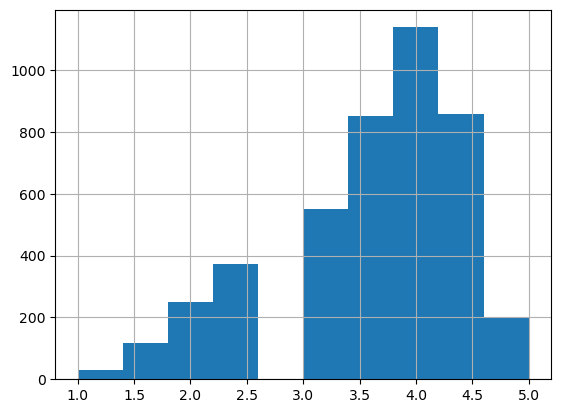

In [81]:
print(business_df["stars"].value_counts())
business_df["stars"].hist()

5    234953
4    150610
3     68269
1     52162
2     41800
Name: stars, dtype: int64


<Axes: >

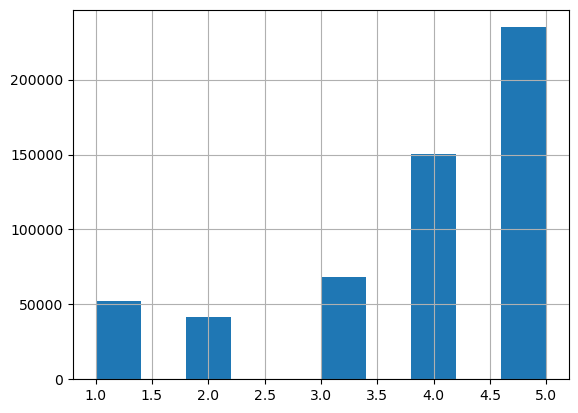

In [82]:
print(review_df["stars"].value_counts())
review_df["stars"].hist()

In [83]:
review_df["business_id"].value_counts()

ytynqOUb3hjKeJfRj5Tshw    5778
PP3BBaVxZLcJU54uP_wL6Q    4293
IkY2ticzHEn4QFn8hQLSWg    3428
9PZxjhTIU7OgPIzuGi89Ew    3264
ctHjyadbDQAtUFfkcAFEHw    3173
                          ... 
k6BLeAGKHZqzp2qhmVjlQg       5
AhBeA8m8iNP_b5jRORMlyg       5
39Vq4--74ljOpcFqn6vbGw       5
yAwSBNIaS2OaRcwuPTJOoQ       5
BEuGzy5gxtGyOEk8iwDfTg       5
Name: business_id, Length: 4372, dtype: int64